<a href="https://colab.research.google.com/github/debsa2000/EED380_AppliedDeepLearning/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [295]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

sns.set(style='white', context='notebook', palette='deep')

import warnings
warnings.filterwarnings("ignore")

# Data

In [296]:
# Load the data
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

In [297]:
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [298]:
test

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,183,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,252,20,0,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [299]:
train.isnull().any().describe()

count       785
unique        1
top       False
freq        785
dtype: object

In [300]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

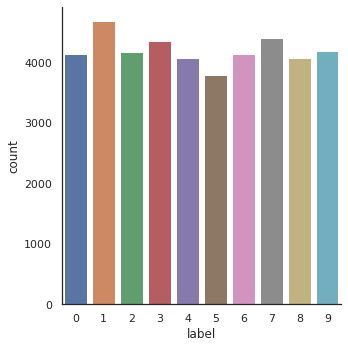

In [301]:
# label count bar graph
sns.catplot(x="label",kind="count", data=train)

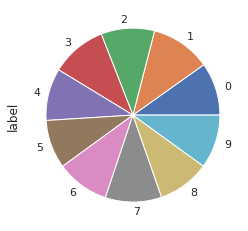

In [302]:
# pie chart for label distribution
train.groupby("label")["label"].count().plot(kind="pie")


In [303]:
Y_train = train["label"]
X_train = train.drop(["label"],axis = 1)
X_test = test

In [304]:
# getting indexes of first 10 occurences for each number

list_of_indexes = []

for i in range(10):
    for nr in range(10):
        ix = Y_train[Y_train==nr].index[i]
        list_of_indexes.append(ix)


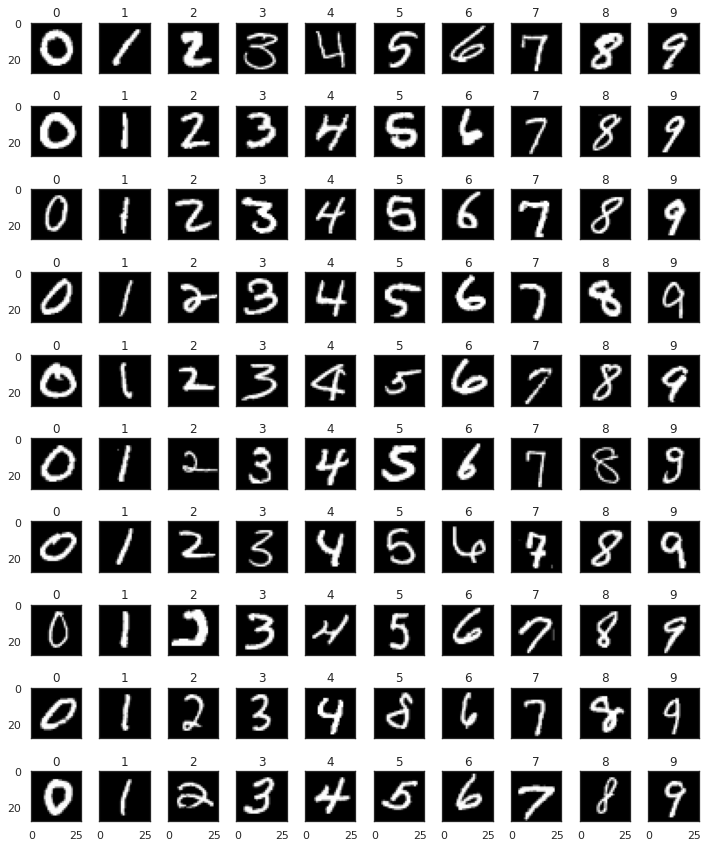

In [305]:
# plotting first 10 handwritten samples for each digit
fig, axs = plt.subplots(10, 10, sharex=True, sharey=True, figsize=(10,12))
axs = axs.flatten()

for n, i in enumerate(list_of_indexes):
    im = X_train.iloc[i]
    im = im.values.reshape(-1,28,28,1)
    axs[n].imshow(im[0,:,:,0], cmap=plt.get_cmap('gray'))
    axs[n].set_title(Y_train[i])

plt.tight_layout()  

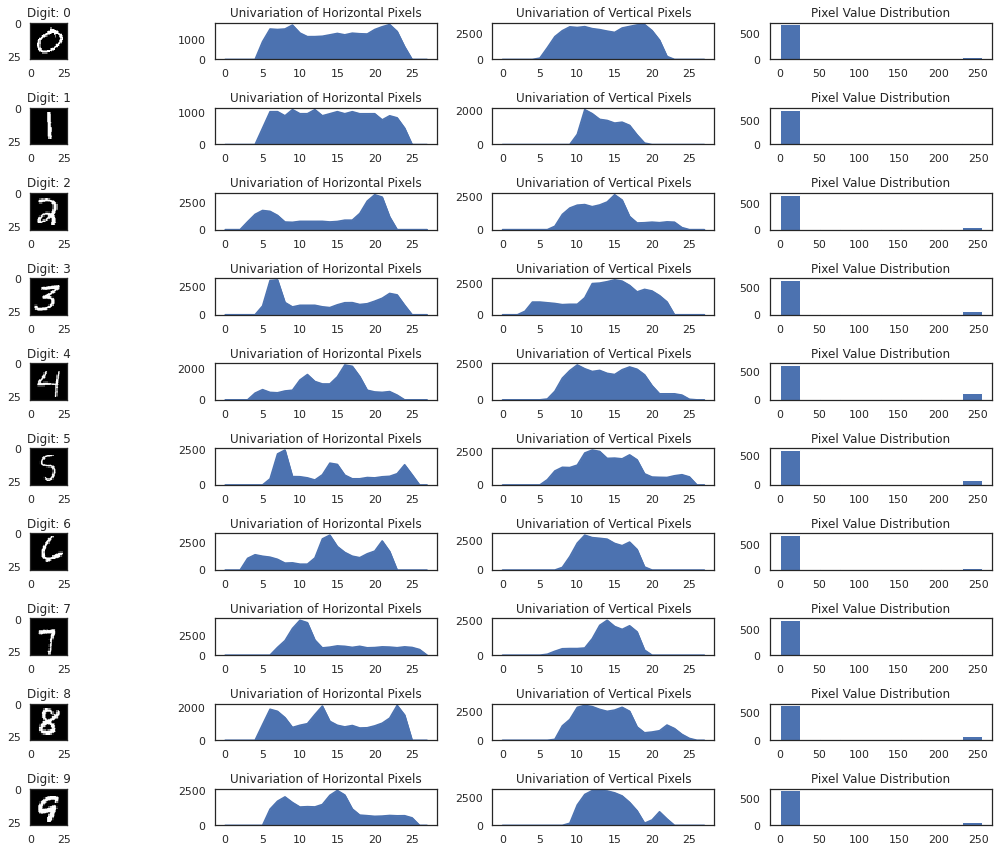

In [306]:
# plotting pixel value distribution

plt.figure(figsize=(15, 12))
j = 1
for i in range(10) :
    plt.subplot(10,4,j)
    j +=1
    plt.imshow(train[Y_train == i].sample(1).drop(labels = ["label"],axis = 1).values.reshape(28, 28), cmap='gray', interpolation='none')
    plt.title("Digit: {}".format(i))
    plt.subplot(10,4,j)
    j +=1
    pd.DataFrame(train[Y_train == i].sample(1).drop(labels = ["label"],axis = 1).values.reshape(28, 28)).sum(axis = 1).plot.area(title = 'Univariation of Horizontal Pixels')
    plt.subplot(10,4,j)
    j +=1
    pd.DataFrame(train[Y_train == i].sample(1).drop(labels = ["label"],axis = 1).values.reshape(28, 28)).sum(axis = 0).plot.area(title = 'Univariation of Vertical Pixels')
    plt.subplot(10,4,j)
    j +=1
    plt.hist(train[Y_train == i].sample(1).drop(labels = ["label"],axis = 1))
    plt.title("Pixel Value Distribution")
plt.tight_layout()

# Preprocessing

In [307]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)


In [308]:
X_train.shape, Y_train.shape

((37800, 784), (37800,))

In [309]:
X_val.shape, Y_val.shape

((4200, 784), (4200,))

In [310]:
X_test.shape

(28000, 784)

In [311]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

In [312]:
# # Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
# X_train = X_train.values.reshape(-1,28,28,1)
# X_test = X_test.values.reshape(-1,28,28,1)
# X_val = X_val.values.reshape(-1,28,28,1)

# X_train.shape, X_val.shape, X_test.shape

In [313]:
# Label Encoding: One Hot Encoding (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])

Y_train = keras.utils.to_categorical(Y_train, num_classes = 10)
Y_val = keras.utils.to_categorical(Y_val, num_classes=10)

In [314]:
Y_train.shape, Y_val.shape

((37800, 10), (4200, 10))

# Modelling

## Simplest Model

### Defining, Compiling and Fitting the Model

In [315]:
model_simple = Sequential()
model_simple.add(Dense(64, activation="sigmoid", input_shape=(784,)))
model_simple.add(Dense(10, activation="softmax"))

In [316]:
model_simple.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_69 (Dense)             (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [317]:
model_simple.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.01), metrics=["accuracy"])

In [318]:
history_simple = model_simple.fit(x=X_train, y=Y_train, batch_size=128, epochs=50, verbose=0, validation_data=(X_val, Y_val))

### Evaluating the model

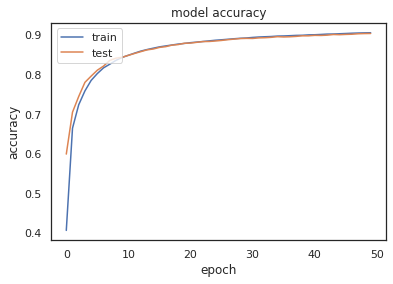

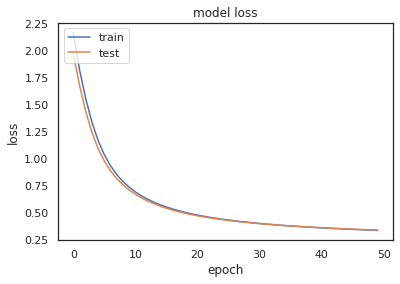

In [319]:
def plot_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
plot_history(history_simple)

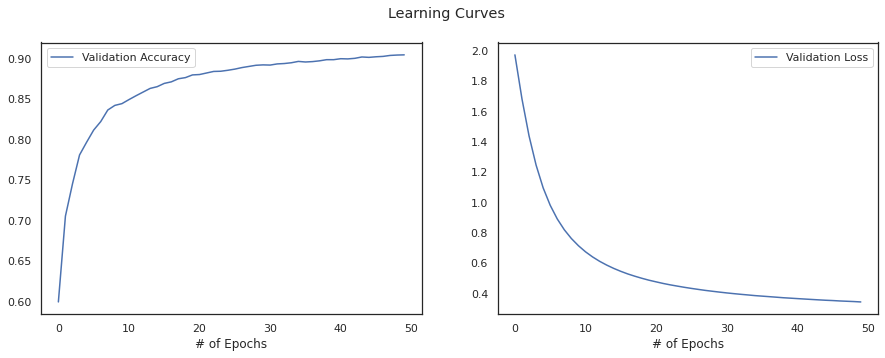

In [320]:
val_loss = history_simple.history["val_loss"]
val_accuracy = history_simple.history["val_acc"]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(x=range(0,len(val_accuracy)), y=val_accuracy, ax=ax[0], label="Validation Accuracy")
sns.lineplot(x=range(0,len(val_loss)), y=val_loss, ax=ax[1], label="Validation Loss")

ax[0].set_xlabel("# of Epochs")
ax[1].set_xlabel("# of Epochs")

plt.suptitle("Learning Curves")
plt.show()

In [321]:
#Print loss and accuracy
model_simple.evaluate(X_val, Y_val)

[0.34111300576300846, 0.9040476]

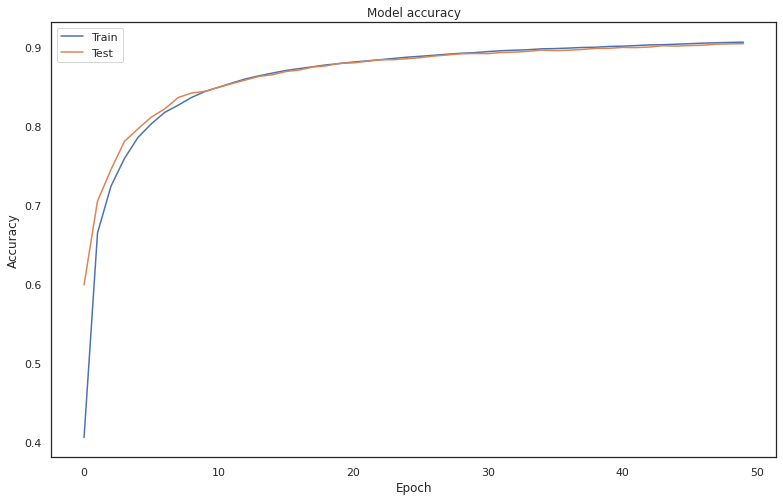

In [322]:
plt.subplots(figsize=(13, 8))
plt.plot(history_simple.history['acc'])
plt.plot(history_simple.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

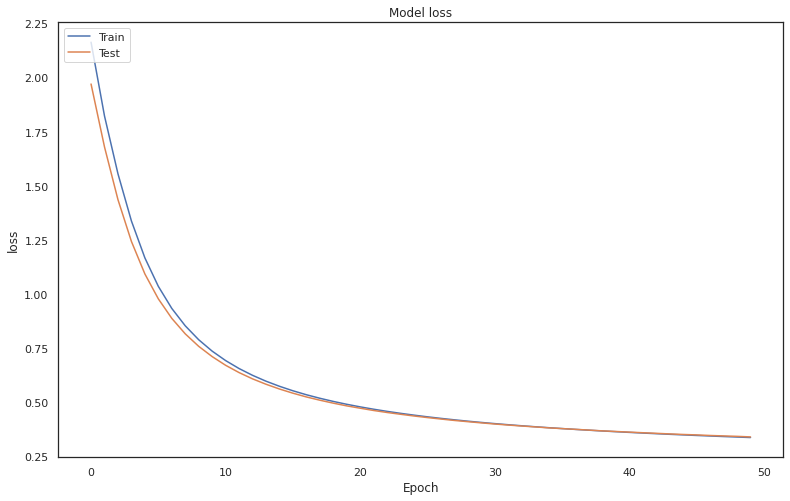

In [323]:
plt.subplots(figsize=(13, 8))
plt.plot(history_simple.history['loss'])
plt.plot(history_simple.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [324]:
#Prediction
p = model_simple.predict(X_val)
p = (p > 0.5)
print('ACCURACY OF SIMPLEST MODEL: %.3f%%' % (accuracy_score(Y_val, p)*100))
print('---------')
print(classification_report(Y_val, p))

ACCURACY OF SIMPLEST MODEL: 86.881%
---------
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       411
           1       0.96      0.96      0.96       485
           2       0.94      0.84      0.89       403
           3       0.92      0.85      0.89       418
           4       0.95      0.90      0.92       461
           5       0.92      0.75      0.82       372
           6       0.96      0.90      0.93       413
           7       0.94      0.86      0.90       446
           8       0.91      0.82      0.87       382
           9       0.90      0.82      0.86       409

   micro avg       0.94      0.87      0.90      4200
   macro avg       0.93      0.87      0.90      4200
weighted avg       0.94      0.87      0.90      4200
 samples avg       0.87      0.87      0.87      4200



### Saving the model

In [325]:
model_simple.save("simplest_model.hd5")
# model = keras.models.load_model("model.hd5")
# model.summary()

# Experimentation

In [243]:
# Helper Functions
class NeuralNetwork():
    def __init__(self, name, batch_size, epochs, learning_rate, verbose):
        self.name = name
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.verbose = verbose
        self.model = Sequential()
        
    def add_(self, layer):
        self.model.add(layer)

    def compile_and_fit(self):
        self.model.compile(loss="mean_squared_error", optimizer=SGD(lr=self.learning_rate), metrics=["accuracy"])
        self.history = self.model.fit(x=X_train,
                                      y=Y_train,
                                      batch_size=self.batch_size,
                                      epochs=self.epochs,
                                      verbose=self.verbose,
                                      validation_data=(X_val, Y_val))
        self.val_loss = self.history.history["val_loss"]
        self.val_accuracy = self.history.history["val_acc"]
    
    def plot_learning_curves(self):
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        
        sns.lineplot(x=range(0,len(self.val_acc)), y=self.val_acc, ax=ax[0], label="Validation Accuracy")
        sns.lineplot(x=range(0,len(self.val_loss)), y=self.val_loss, ax=ax[1], label="Validation Loss")

        ax[0].set_xlabel("# of Epochs")
        ax[1].set_xlabel("# of Epochs")

        plt.suptitle("Learning Curves: {}".format(self.name))
        plt.show()

    def evaluate_(self):
        return self.model.evaluate(X_valid, y_valid)
    
    def save(self, filename):
        self.model.save("working/"+filename+".hd5")
        
    def summary_(self):
        return self.model.summary()

In [223]:
def compare_learning_curves(models):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    
    for model in models:
        sns.lineplot(x=range(0,len(model.val_accuracy)), y=model.val_accuracy, ax=ax[0], label=model.name)
        sns.lineplot(x=range(0,len(model.val_loss)), y=model.val_loss, ax=ax[1], label=model.name)
    
    ax[0].set_xlabel("# of Epochs")
    ax[1].set_xlabel("# of Epochs")

    ax[0].set_title("Validation Accuracy")
    ax[1].set_title("Validation Loss")

    plt.suptitle("Learning Curves")
    plt.show()

## Batch Size

In [224]:
batch_sizes = [8, 16, 32, 64, 128, 256]
n_epochs = 50

In [225]:
accuracy = pd.DataFrame(columns=batch_sizes, index=range(n_epochs))
loss = pd.DataFrame(columns=batch_sizes, index=range(n_epochs))
accuracy["Epoch"] = range(n_epochs)
loss["Epoch"] = range(n_epochs)

In [228]:
for batch_size in batch_sizes:
    model = Sequential()
    model.add(Dense(64, activation="sigmoid", input_shape=(784,)))
    model.add(Dense(10, activation="softmax"))
    model.compile(loss="mean_squared_error", optimizer=SGD(lr=0.01), metrics=["accuracy"])
    
    hist = model.fit(x=X_train,
              y=Y_train,
              batch_size=batch_size,
              epochs=n_epochs,
              verbose=0,
              validation_data=(X_val, Y_val))
    
    accuracy[batch_size] = hist.history["val_acc"]
    loss[batch_size] = hist.history["val_loss"]

In [229]:
accuracy_melt = accuracy.melt(value_name="Accuracy", var_name="Batch Size", id_vars=["Epoch"])
loss_melt = loss.melt(value_name="Loss", var_name="Batch Size", id_vars=["Epoch"])

accuracy_melt["Batch Size"] = accuracy_melt["Batch Size"].astype(object)
loss_melt["Batch Size"] = loss_melt["Batch Size"].astype(object)

In [230]:
accuracy_melt = accuracy.melt(value_name="Accuracy", var_name="Batch Size", id_vars=["Epoch"])
loss_melt = loss.melt(value_name="Loss", var_name="Batch Size", id_vars=["Epoch"])

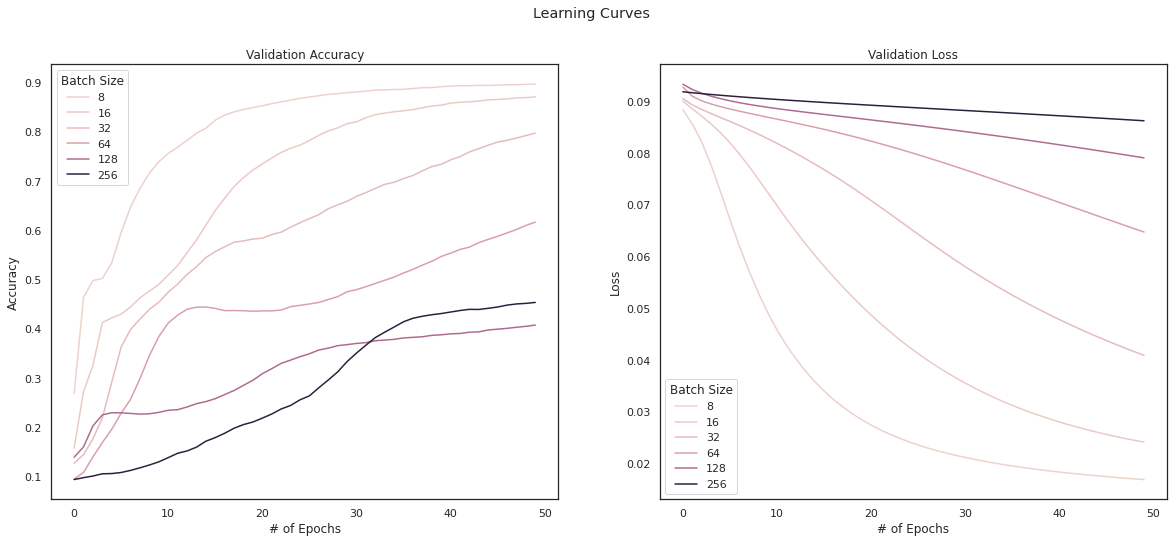

In [231]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(x="Epoch", y="Accuracy", hue="Batch Size", data=accuracy_melt, ax=ax[0], legend="full")
sns.lineplot(x="Epoch", y="Loss", hue="Batch Size", data=loss_melt, ax=ax[1], legend="full")

ax[0].set_title("Validation Accuracy")
ax[1].set_title("Validation Loss")

ax[0].set_xlabel("# of Epochs")
ax[1].set_xlabel("# of Epochs")

plt.suptitle("Learning Curves")
plt.show()

## Learning Rate

In [241]:
n_epochs = 100
batch_size = 128
verbose = 0

In [244]:
learning_rate = 100
nn_lr_100 = NeuralNetwork("LR = {}".format(learning_rate), batch_size, n_epochs, learning_rate, verbose)
nn_lr_100.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_lr_100.add_(Dense(10, activation="softmax"))

learning_rate = 1000
nn_lr_1000 = NeuralNetwork("LR = {}".format(learning_rate), batch_size, n_epochs, learning_rate, verbose)
nn_lr_1000.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_lr_1000.add_(Dense(10, activation="softmax"))

learning_rate = 10
nn_lr_10 = NeuralNetwork("LR = {}".format(learning_rate), batch_size, n_epochs, learning_rate, verbose)
nn_lr_10.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_lr_10.add_(Dense(10, activation="softmax"))

learning_rate = 1
nn_lr_1 = NeuralNetwork("LR = {}".format(learning_rate), batch_size, n_epochs, learning_rate, verbose)
nn_lr_1.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_lr_1.add_(Dense(10, activation="softmax"))

learning_rate = 0.1
nn_lr_p1 = NeuralNetwork("LR = {}".format(learning_rate), batch_size, n_epochs, learning_rate, verbose)
nn_lr_p1.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_lr_p1.add_(Dense(10, activation="softmax"))

learning_rate = 0.01 # default
nn_lr_p01 = NeuralNetwork("LR = {}".format(learning_rate), batch_size, n_epochs, learning_rate, verbose)
nn_lr_p01.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_lr_p01.add_(Dense(10, activation="softmax"))

learning_rate = 0.001
nn_lr_p001 = NeuralNetwork("LR = {}".format(learning_rate), batch_size, n_epochs, learning_rate, verbose)
nn_lr_p001.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_lr_p001.add_(Dense(10, activation="softmax"))

nn_lr_100.compile_and_fit()
nn_lr_1000.compile_and_fit()
nn_lr_10.compile_and_fit()
nn_lr_1.compile_and_fit()
nn_lr_p1.compile_and_fit()
nn_lr_p01.compile_and_fit()
nn_lr_p001.compile_and_fit()

In [245]:
learning_rate = 0.1
nn_lr_p1 = NeuralNetwork("LR = {}".format(learning_rate), batch_size, n_epochs, learning_rate, verbose)
nn_lr_p1.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_lr_p1.add_(Dense(10, activation="softmax"))
nn_lr_p1.compile_and_fit()

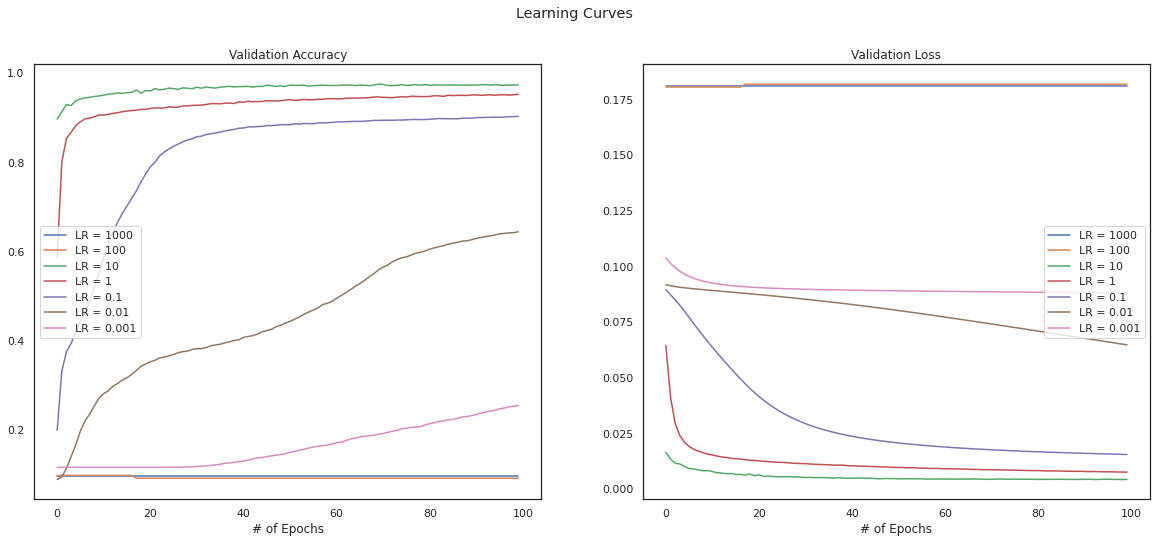

In [246]:
compare_learning_curves([nn_lr_1000, nn_lr_100, nn_lr_10, nn_lr_1, nn_lr_p1, nn_lr_p01, nn_lr_p001])

## Activation Functions

In [249]:
n_epochs = 100
batch_size = 128
learning_rate = 0.01
verbose = 0

In [250]:
nn_sigmoid = NeuralNetwork("Sigmoid", batch_size, n_epochs, learning_rate, verbose)
nn_sigmoid.add_(Dense(64, activation="sigmoid", input_shape=(784,)))
nn_sigmoid.add_(Dense(10, activation="softmax"))
nn_sigmoid.compile_and_fit()

nn_tanh = NeuralNetwork("Tanh", batch_size, n_epochs, learning_rate, verbose)
nn_tanh.add_(Dense(64, activation="tanh", input_shape=(784,)))
nn_tanh.add_(Dense(10, activation="softmax"))
nn_tanh.compile_and_fit()

nn_relu = NeuralNetwork("ReLU", batch_size, n_epochs, learning_rate, verbose)
nn_relu.add_(Dense(64, activation="relu", input_shape=(784,)))
nn_relu.add_(Dense(10, activation="softmax"))
nn_relu.compile_and_fit()

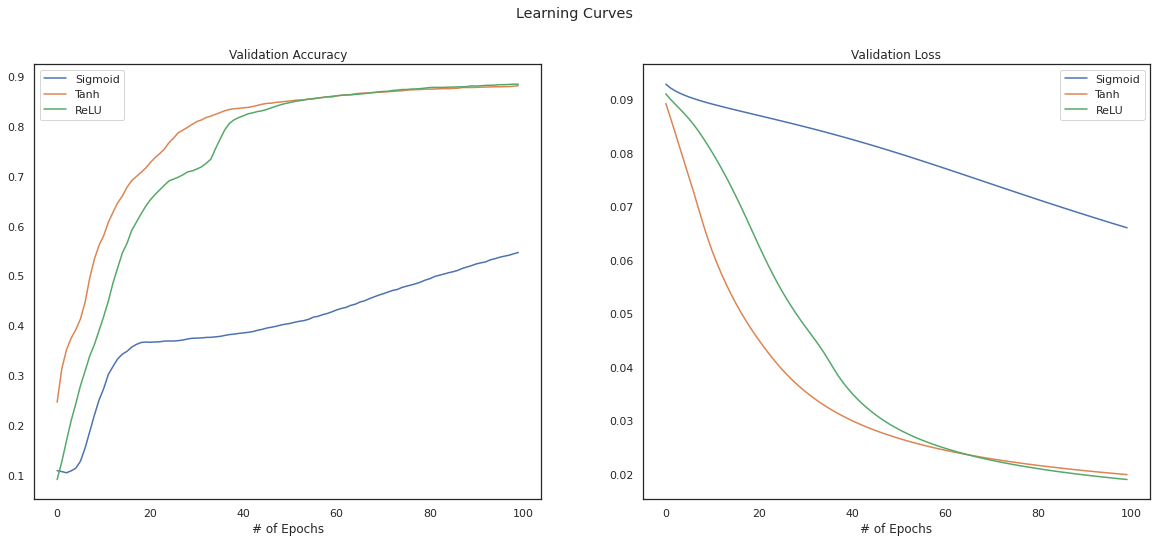

In [251]:
compare_learning_curves([nn_sigmoid, nn_tanh, nn_relu])

# Notebook2


## Defining Network Architecture


In [ ]:
# Network Parameters
n_hidden_1 = 512 # 1st layer number of neurons
n_hidden_2 = 128 # 2nd layer number of neurons
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

In [ ]:
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

# keep_prob: we will be using these placeholders when we use dropouts, while testing model
keep_prob = tf.placeholder(tf.float32)
keep_prob_input = tf.placeholder(tf.float32)

## Sigmoid with Xavier Initialization

If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(ni+ni+1).
*   h1 => σ=√(2/(fan_in+fan_out+1) = 0.039 => N(0,σ) = N(0,0.039)
*   h2 => σ=√(2/(fan_in+fan_out+1) = 0.055 => N(0,σ) = N(0,0.055)
*   out => σ=√(2/(fan_in+fan_out+1) = 0.120 => N(0,σ) = N(0,0.120)

In [ ]:
weights_sgd = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=0.039, mean=0)),    #784x512 # sqrt(2/(784+512)) = 0.039
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=0.055, mean=0)), #512x128 # sqrt(2/(512+128)) = 0.055
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes],stddev=0.120, mean=0))  #128x10
}

## ReLU with He Normal initialization

If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(ni).
*   h1 => σ=√(2/(fan_in+1) = 0.062 => N(0,σ) = N(0,0.062)
*   h2 => σ=√(2/(fan_in+1) = 0.125 => N(0,σ) = N(0,0.125)
*   out => σ=√(2/(fan_in+1) = 0.120 => N(0,σ) = N(0,0.120)

In [ ]:
weights_relu = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=0.062, mean=0)),    #784x512
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=0.125, mean=0)), #512x128
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes],stddev=0.120, mean=0))  #128x10
}

In [ ]:
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),             #512x1
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),             #128x1
    'out': tf.Variable(tf.random_normal([n_classes]))              #10x1
}

# Parameters
training_epochs = 25
learning_rate = 0.001
batch_size = 250
display_step = 1

## Model 1: input (784) - sigmoid(512) - sigmoid(128) - softmax(output 10)

In [ ]:
# Create model
def multilayer_perceptron(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    # Hidden layer with Sigmoid activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.sigmoid(layer_1)
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with Sigmoid activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.sigmoid(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

# Final Model

In [328]:
Y_train_final = train["label"]
X_train_final = train.drop(["label"],axis = 1)
X_test_final = test

In [329]:
X_train_final = train / 255.0
X_test_final = test / 255.0

In [331]:
X_train_final.shape

(42000, 785)

In [333]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train_final = X_train_final.values.reshape(-1,28,28,1)
X_test_final = X_test_final.values.reshape(-1,28,28,1)


ValueError: ignored

In [293]:
X_train_final = X_train.values.reshape(-1, 28, 28, 1)
X_test_final = X_test.values.reshape(-1, 28, 28, 1)

In [294]:
# CNN model 
# Architecture: Input -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Output
model_final = Sequential()

model_final.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1), name = "CONV_1"))
model_final.add(BatchNormalization(name = "BN_1"))
model_final.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', name = "CONV_2"))
model_final.add(BatchNormalization(name = "BN_2"))
model_final.add(MaxPool2D(pool_size=(2,2), name = "MAXPOOL_1"))
model_final.add(Dropout(0.25, name = "DROP_1"))

model_final.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu', padding = 'Same', name = "CONV_3"))
model_final.add(BatchNormalization(name = "BN_3"))
model_final.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu', padding = 'Same', name = "CONV_4"))
model_final.add(BatchNormalization(name = "BN_4"))
model_final.add(MaxPool2D(pool_size=(2,2), name = "MAXPOOL_2"))
model_final.add(Dropout(0.25, name = "DROP_2"))

model_final.add(Conv2D(filters = 128, kernel_size = (3,3), activation ='relu', padding = 'Same', name = "CONV_5"))
model_final.add(BatchNormalization(name = "BN_5"))
model_final.add(Conv2D(filters = 128, kernel_size = (3,3), activation ='relu', padding = 'Same', name = "CONV_6"))
model_final.add(BatchNormalization(name = "BN_6"))
model_final.add(MaxPool2D(pool_size=(2,2), name = "MAXPOOL_3"))
model_final.add(Dropout(0.25, name = "DROP_3"))

model_final.add(Flatten(name = "FLAT_1"))
model_final.add(Dense(256, activation = "relu", name = "FC_1"))
model_final.add(BatchNormalization(name = "BN_7"))
model_final.add(Dropout(0.3, name = "DROP_4"))
model_final.add(Dense(10, activation = "softmax", name = "FC_2"))
model_final.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV_1 (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 28, 28, 32)        128       
_________________________________________________________________
CONV_2 (Conv2D)              (None, 28, 28, 32)        25632     
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 28, 28, 32)        128       
_________________________________________________________________
MAXPOOL_1 (MaxPooling2D)     (None, 14, 14, 32)        0         
_________________________________________________________________
DROP_1 (Dropout)             (None, 14, 14, 32)        0         
_________________________________________________________________
CONV_3 (Conv2D)              (None, 14, 14, 64)      

In [292]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("model_final.png")

In [291]:
import gc
best_accuracy = 0
best_batch_size = -1
for batch_size in [32, 64, 128, 256]:
    model_final.compile(optimizer="Adam", loss=["categorical_crossentropy"], metrics = ["accuracy"])
    history = model_final.fit(X_train, Y_train ,epochs=10, batch_size = batch_size, validation_data=(X_val, Y_val), verbose=0)
    acc = history.history["val_accuracy"][-1]
    if acc > best_accuracy:
        best_accuracy = acc
        best_batch_size = batch_size
    print(batch_size, acc)
    gc.collect() # Clear RAM
print("\nBEST -> ", best_batch_size, best_accuracy)

ValueError: ignored

In [ ]:
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [ ]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Set a learning rate annealer - learning rate reduction
callbacks = [
    EarlyStopping(
        monitor = 'val_acc', 
        patience = 10,
        mode = 'max',
        verbose = 1),
    ReduceLROnPlateau(
        monitor = 'val_acc', 
        patience = 3, 
        verbose = 1, 
        factor = 0.5, 
        min_lr = 0.00001)]

In [ ]:
## Model parameters

epochs = 10
batch_size = 64
verbose = 2
step_per_epoch = X_train.shape[0] // batch_size
loss = 'categorical_crossentropy'
learning_rate = 0.1

In [ ]:
# Without data augmentation
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, Y_val), verbose = 2)

In [ ]:
# With data augmentation to prevent overfitting (accuracy 0.99286)
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [ ]:
# Fit the model with data augmentation
history_dataaug = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size), 
                                      epochs = epochs, 
                                      validation_data = (X_val,Y_val), 
                                      verbose = 2, 
                                      steps_per_epoch=X_train.shape[0] // batch_size, 
                                      callbacks=callbacks)

In [ ]:
model.save("finalmodel.hd5")
# model = keras.models.load_model("model.hd5")
# model.summary()